In [1]:
import pickle
import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import callbacks, layers, Sequential
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from dataflow import Flow

In [2]:
data1 = Flow(None, None, None, 'csv/preselected_pKmue_moreFeatures_unequalRatio.csv')
data2 = Flow(None, None, None, 'csv/preselected_pKmue_fullFeatures_equalRatio.csv')
data3 = Flow(None, None, None, 'csv/preselected_pKmue_fullFeatures_equalRatio_restrictedSideband.csv')
data4 = Flow(None, None, None, 'csv/preselected_pKmue_fullPlusFeatures_equalRatio_restrictedSideband.csv')

data = [data2, data3, data4]

In [4]:
df = data4.get_combined_data()
df.columns

Index(['Lb_PT', 'Lb_IPCHI2_OWNPV', 'Lb_ENDVERTEX_CHI2', 'Lb_HOP',
       'LStar_ORIVX_CHI2', 'LStar_DIRA_OWNPV', 'JPs_FD_ORIVX', 'category',
       'ABS_ARTANH_PZ_P', 'MAG_ARSINH_PY_PT', 'SUM_CONE_ISO', 'SUM_LIPCHI2',
       'LB_TRACKISO', 'LN_COS_DIRA'],
      dtype='object')

In [3]:
custom_callbacks = [
    callbacks.EarlyStopping(patience=20, min_delta=0.0005, restore_best_weights=True), 
    callbacks.ReduceLROnPlateau(patience=5, factor=0.2, min_lr=0.001)
    ]

def compile_model(input_shape):
    model = Sequential([
        layers.Dense(16, activation='relu', input_shape=input_shape, kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
    
    return model

In [4]:
def plot_history_curves(history, epochs, model_version='No version', savefig='', off=False):
    if type(history) != dict:
        history = history.history
    
    loss = history['loss']
    val_loss = history['val_loss']
    accuracy = history['binary_accuracy']
    val_accuracy = history['val_binary_accuracy']
    auc = history['auc']
    val_auc = history['val_auc']
    epoch_range = range(1, epochs+1, 1)    

    fig, ax = plt.subplots(1, 3, figsize=(22, 6))
    ax[0].plot(epoch_range, loss, 'r.', label='Training Loss')
    ax[0].plot(epoch_range, val_loss, 'b.', label='Validation Loss')
    ax[1].plot(epoch_range, accuracy, 'r.', label='Training Accuracy')
    ax[1].plot(epoch_range, val_accuracy, 'b.', label='Validation Accuracy')
    ax[2].plot(epoch_range, auc, 'r.', label='Training AUC')
    ax[2].plot(epoch_range, val_auc, 'b.', label='Validation AUC')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.title(model_version)
    plt.legend(frameon=False)
    if savefig != '':
        plt.savefig(savefig)
    if not off:
        plt.show()

def plot_history(model_version, savefig='', off=False):
    history = pickle.load(open(f'train_history/v{model_version}', "rb"))
    nepochs = len(history['loss'])
    plot_history_curves(history, nepochs, model_version, savefig, off)
    

In [5]:
def fit_model(model, train_data, val_data, model_version, callbacks=None, epochs=100, batch_size=512):
    model_history = model.fit(train_data[0], train_data[1], epochs=epochs, batch_size=batch_size, validation_data=val_data, callbacks=callbacks, verbose=1)
    with open(f'train_history/v{model_version}', 'wb') as file_pi:
        pickle.dump(model_history.history, file_pi)
    model.save(f'models/v{model_version}')

In [6]:
def roc_curve(history, y_train, y_val, mversion='No Version', savefig=False, off=False, excl_epochs=0):
    train_signal_eff = history['true_positives']/y_train.value_counts()[1]
    val_signal_eff = history['val_true_positives']/y_val.value_counts()[1]
    # What percentage of total signal events were identified as signal events

    train_background_rej = 1 - (history['false_positives'] / y_train.value_counts()[0])
    val_background_rej = 1 - (history['val_false_positives'] / y_val.value_counts()[0])
    # The number of true positives to total positives
    
    train_background_rej, val_background_rej = train_background_rej[excl_epochs:], val_background_rej[excl_epochs:]
    train_signal_eff, val_signal_eff = train_signal_eff[excl_epochs:], val_signal_eff[excl_epochs:]
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(train_signal_eff, train_background_rej,  label='Training', s=2)
    ax.scatter(val_signal_eff, val_background_rej, label='Validation', s=2)
    ax.set_ylabel('Background Rejection (1 - False Positive Rate)')
    ax.set_xlabel('Signal Efficiency (True Positive Rate)')
    plt.title(f'Model {mversion}')
    plt.legend()
    if savefig != False:
        plt.savefig(savefig)
    if not off:
        plt.show()

In [7]:
def run_all(data_objs):
    # Give it a list of data objects
    for i, d in enumerate(data_objs):
        (X_train, y_train), (X_val, y_val), (X_test, y_test) = d.get_train_val_test_split()
        model = compile_model((X_train.shape[1],))
        #fit_model(model, (X_train, y_train), (X_val, y_val), f'4.2.{i}', callbacks=custom_callbacks)
        plot_history(f'4.2.{i}', f'train_history_imgs/4.2.{i}.png', off=True)
        history = pickle.load(open(f'train_history/v4.2.{i}', "rb"))
        roc_curve(history, y_train, y_val, mversion=f'4.2.{i}', savefig=f'train_history_imgs/4.2.{i}_roc.png', off=True, excl_epochs=5)
        # Dont plot the first 5 epochs they are dumb
    

2022-02-20 20:22:53.986144: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-20 20:22:53.989717: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


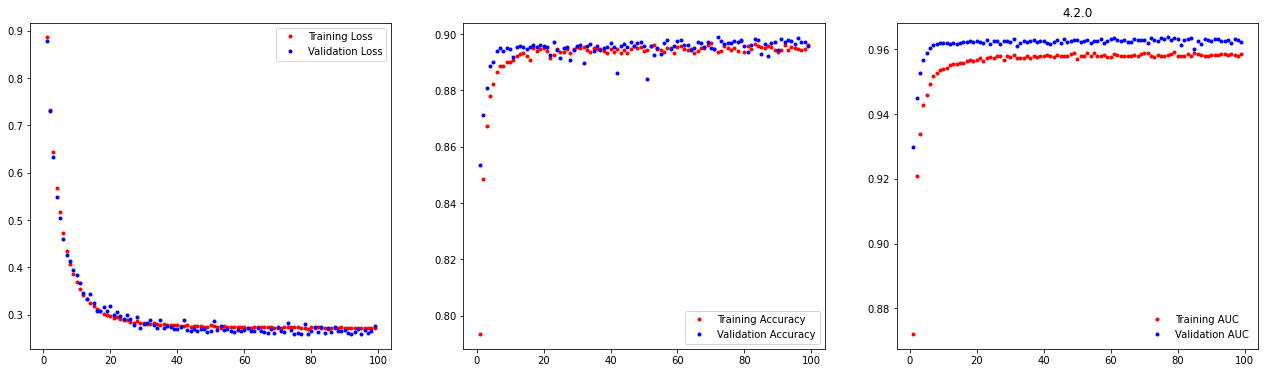

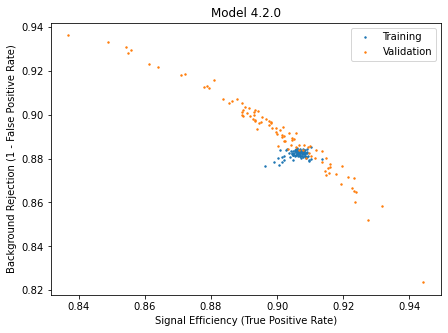

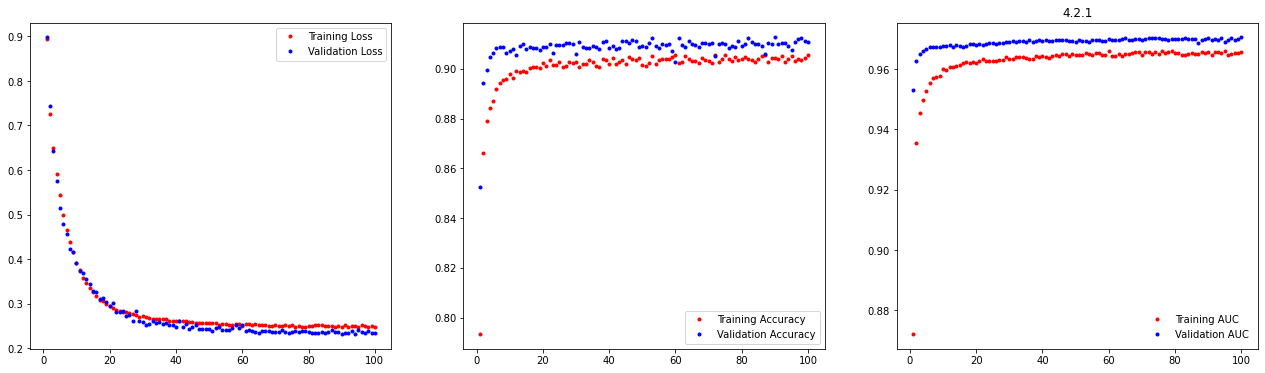

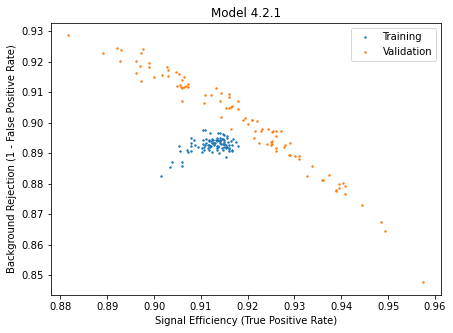

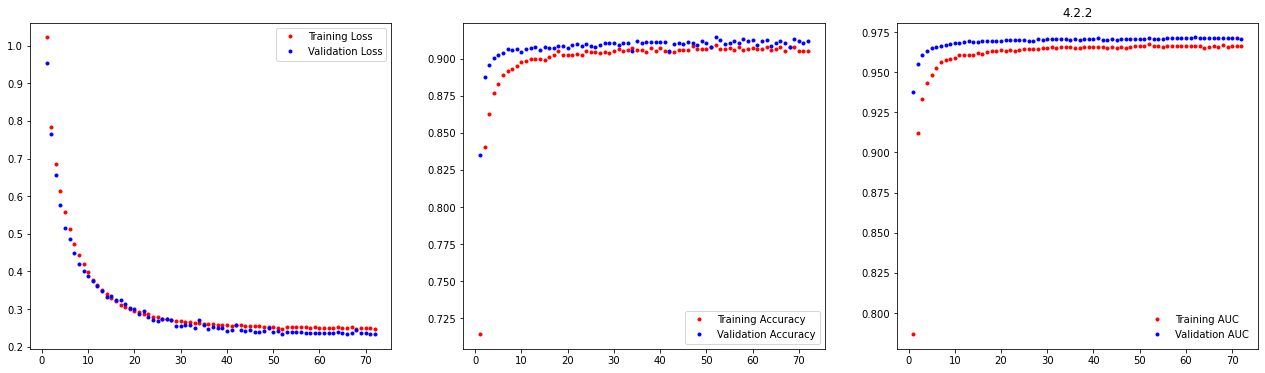

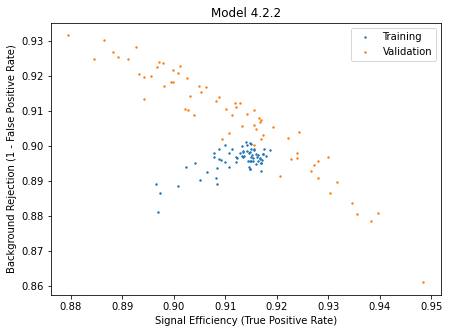

In [8]:
run_all(data)

## Plot Prediction Distribution 
Now we plot the distribution of the assigned probabilities across the train, validation and test data. Split colours via the dataset and solid or dashed being either signal or bakground. 

In [9]:
model = tf.keras.models.load_model('models/v4.2.2')
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data4.get_train_val_test_split()

X_test_sig = X_test[y_test == 1]
X_test_bg = X_test[y_test == 0]

X_val_sig = X_val[y_val == 1]
X_val_bg = X_val[y_val == 0]

X_train_sig = X_train[y_train == 1]
X_train_bg = X_train[y_train == 0]

tests = model.predict(X_test_sig)
vals = model.predict(X_val_sig)
trains = model.predict(X_train_sig)
testb = model.predict(X_test_bg)
valb = model.predict(X_val_bg)
trainb = model.predict(X_train_bg)

2022-02-20 20:22:57.981953: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-20 20:22:57.995735: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400145000 Hz


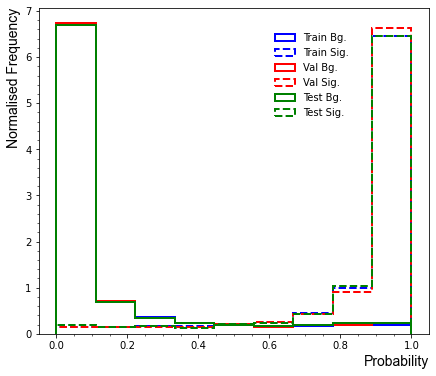

In [13]:
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

bins = np.linspace(0, 1, 10)
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

fonts = {'fontname':'Arial'}

ax.hist(trainb, bins=bins, histtype='step', label='Train Bg.', density=True, color='b', linewidth=2)
ax.hist(trains, bins=bins, histtype='step', label='Train Sig.', density=True, linestyle='dashed', color='b', linewidth=2)

ax.hist(valb, bins=bins, histtype='step', label='Val Bg.', density=True, color='r', linewidth=2)
ax.hist(vals, bins=bins, histtype='step', label='Val Sig.', density=True, linestyle='dashed', color='r', linewidth=2)

ax.hist(testb, bins=bins, histtype='step', label='Test Bg.', density=True, color='g', linewidth=2)
ax.hist(tests, bins=bins, histtype='step', label='Test Sig.', density=True, linestyle='dashed', color='g', linewidth=2)

plt.ylabel('Normalised Frequency', horizontalalignment='right', y=1.0, fontsize=14, **fonts)
plt.xlabel('Probability', horizontalalignment='right', x=1.0, fontsize=14, **fonts)
plt.legend(loc='upper center', bbox_to_anchor=(0.7, 0.95), ncol=1, fancybox=False, shadow=True, frameon=False)
plt.savefig('predicted_prob_dist.png')
plt.show()

# GREEN = #008000 (BACKGROUND)
# RED = #f40000 (SIGNAL)